## Introduction

Alternative task

Problematic word

Problems

Visual corrections

Negative samples

Balancing

Merging of the corpora

## TSA task

Problematic verb.

### Creating dictionary


First, let's define the list of corpora we will use in our bundle. Assume we have three corpora: news, publicistics and books.

In [1]:
from tg.grammar_ru import Loc

corpora = [
    Loc.corpus_path/'books.base.zip',
    Loc.corpus_path/'pub.base.zip'
]

Not every sentence in the corpora contains problematic word, so first we need to detect the sentences that are required in the bundle. For this particular task we will use a dictionary approach: we will scan the corpora and find verbs that are presented there in both -тся and -ться forms.

In [2]:
from tg.grammar_ru import CorpusReader
from tg.grammar_ru.tasks.alternative import tsa
from yo_fluq_ds import *
from pathlib import Path

dict_path = Path('tsa-dict.json')

if not dict_path.is_file():
    en = CorpusReader.read_frames_from_several_corpora(corpora).feed(fluq.with_progress_bar())
    good_words = tsa.build_dictionary(en)
    FileIO.write_json(list(good_words), dict_path)
else:
    good_words = set(FileIO.read_json(dict_path))

### Computing buckets

We want an equal representation of the sentences of different lengths, as well as sentences from different corpora. To do this, we will scan the corpora again, consider only the sentences that have a problematic word, and then compute the length of each such sentence.

First, we need a filter that will select the problematic sentences. We will use the filter that selects only the sentences with the words from the given dictionary. To view its functionality, we will create a demonstration dataframe:


In [3]:
from tg.grammar_ru import Separator
from tg.grammar_ru.tasks.alternative import DictionaryFilterer

df = Separator.separate_string('Мне нравится борщ. Он вкусный.')
filter = DictionaryFilterer(good_words)
filter.filter(df)

,word_id,sentence_id,word_index,paragraph_id,word_tail,word,word_type,word_length,is_target
0,0,0,0,0,1,Мне,ru,3,False
1,1,0,1,0,1,нравится,ru,8,True
2,2,0,2,0,0,борщ,ru,4,False
3,3,0,3,0,1,.,punct,1,False


As we can see, only the first sentences is included. Also, there is `is_target` column that indicates if the word is problematic.

Now, we scan the corpora:

In [9]:
from tg.grammar_ru.ml.corpus import BucketBalancer



buckets_path = Path('tsa-buckets.parquet')

if not buckets_path.is_file():
    en = CorpusReader.read_frames_from_several_corpora(corpora).feed(fluq.with_progress_bar()).select(filter.filter)
    buckets_df = BucketBalancer.collect_buckets(en)
    buckets_df.to_parquet(buckets_path)
else:
    buckets_df = pd.read_parquet(buckets_path)


  0%|          | 0/69416 [00:00<?, ?it/s]

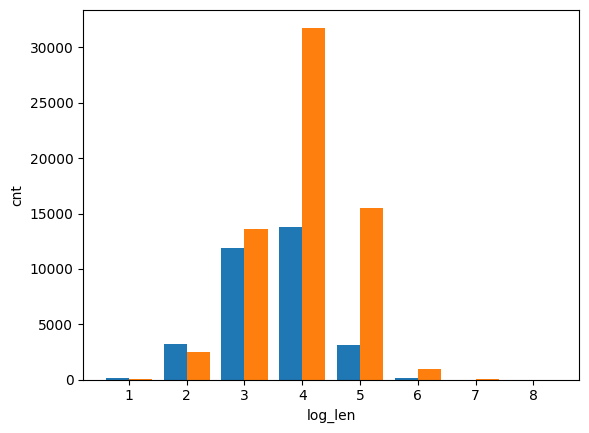

In [15]:
from tg.common.analysis import grbar_plot

ax = grbar_plot(
    buckets_df.groupby(['corpus_id','log_len']).size().to_frame('cnt').reset_index(),
    value_column='cnt',
    color_column='corpus_id',
    group_column='log_len'
)
ax.legend()

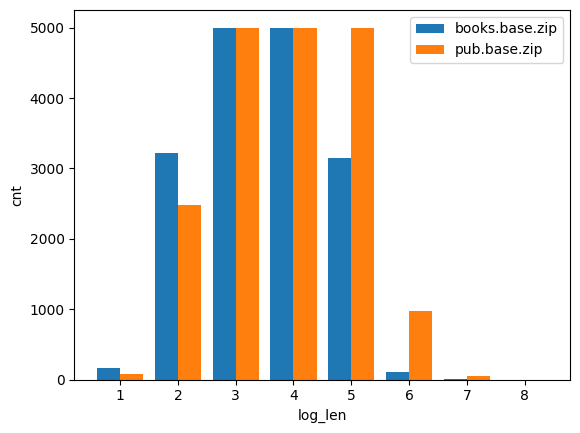

In [24]:
import numpy as np
take_df = buckets_df
take_df['random'] = np.random.rand(take_df.shape[0])
take_df = take_df.feed(fluq.add_ordering_column(['corpus_id','log_len'],'random'))
take_df = take_df.loc[take_df.order<5000]


ax = grbar_plot(
    take_df.groupby(['corpus_id','log_len']).size().to_frame('cnt').reset_index(),
    value_column='cnt',
    color_column='corpus_id',
    group_column='log_len'
)
ax.legend()


### Negative samples

